In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pytz
import xlrd
import datetime

Funkcje do operacji na unixowym zapisie czasu

In [2]:
def icmp_dateformat_to_datetime(icmp_time_mark):
    datetime_date = xlrd.xldate_as_datetime(icmp_time_mark, 0)
    datetime_date = datetime_date + datetime.timedelta(hours=1)
    return datetime_date

def datetime_to_icmp_dateformat(datetime_date):
    icmp_reference_date = datetime.datetime(1899, 12, 30, 0, 0, 0, 0)
    icmp_date_mark = datetime_date - datetime.timedelta(hours=1)
    begining_of_day = datetime.datetime(datetime_date.year, datetime_date.month, datetime_date.day, 0, 0, 0, 0)
    days_diff = (icmp_date_mark - icmp_reference_date).days
    time_diff_timestamp = icmp_date_mark.timestamp() - begining_of_day.timestamp()
    time_fraction = time_diff_timestamp / (24.0 * 3600.0)
    icmp_date_mark = days_diff + time_fraction
    return icmp_date_mark

def timestamp_to_icmp_dateformat(timestamp):
    datetime_date = datetime.datetime.fromtimestamp(timestamp)
    return datetime_to_icmp_dateformat(datetime_date)


In [3]:
def Timestamp_diff(timestamp1, timestamp2):
    diff = timestamp1 - timestamp2
    diff_milliseconds = diff.total_seconds() * 1000

    return int(diff_milliseconds)//5

In [4]:
def fill_missing_steps(df):
    """
    Uzupełnia brakujące wartości pomiaru czasu jako NaN
    """
    rows = []
    
    # Iteracja po oryginalnych wierszach
    for i in range(len(df) - 1):

        # Sprawdzenie różnicy między obecnym wierszem a następnym
        diff = df.iloc[i + 1]['DateTime'] - df.iloc[i]['DateTime']

        # W 349 wierszach powtórzyły się timestampy, więc eliminuje ten błąd
        if diff != 0:
            rows.append(df.iloc[i].to_dict())

        while diff > 1:
            new_row = {
                'DateTime': df.iloc[i]['DateTime'] + 1,
                'abp[mmHg]': np.nan
            }
            rows.append(new_row)
            df.iat[i, df.columns.get_loc('DateTime')] += 1  # Aktualizacja wartości w oryginalnej ramce danych
            diff -= 1

    # Dodanie ostatniego wiersza
    rows.append(df.iloc[-1].to_dict())
    
    # Tworzenie nowej ramki danych z listy słowników
    new_data = pandas.DataFrame(rows)
    return new_data

Wczytanie i obróbka danych

In [5]:
data_1 = pandas.read_csv('C:/Users/Ignacy/Desktop/Brainlab/r2.csv', sep=';')
data_1 = data_1.apply(lambda x: x.str.replace(',', '.'))
data_1 = data_1.apply(lambda x: [float(num) for num in x])

In [6]:
data_1['DateTime'] = [icmp_dateformat_to_datetime(date) for date in data_1['DateTime']]
data_1

,DateTime,abp[mmHg]
0,2014-11-03 12:43:59.200,78.71
1,2014-11-03 12:43:59.205,78.71
2,2014-11-03 12:43:59.210,78.42
3,2014-11-03 12:43:59.215,78.42
4,2014-11-03 12:43:59.220,78.20
...,...,...
301499,2014-11-03 13:15:34.050,94.40
301500,2014-11-03 13:15:34.055,93.53
301501,2014-11-03 13:15:34.060,93.53
301502,2014-11-03 13:15:34.065,92.79


A więc badania pomiary trwały około 32 minuty

In [7]:
data_1['DateTime'] = [Timestamp_diff(date, data_1['DateTime'][0]) for date in data_1['DateTime']]
data_1 = fill_missing_steps(data_1)
data_1

,DateTime,abp[mmHg]
0,0.0,78.71
1,1.0,78.71
2,2.0,78.42
3,3.0,78.42
4,4.0,78.20
...,...,...
378970,378970.0,94.40
378971,378971.0,93.53
378972,378972.0,93.53
378973,378973.0,92.79


# Funkcja do wizualizacji danych

In [8]:
def plot_and_save_subframes(df, slice_size=24000, discard_remainder=True, nan_kernel=0.2):
    """
    Dzieli ramkę danych na odcinki po slice_size wierszy(domyślnie 2 minuty) i tworzy dla każdego odcinka osobny wykres.
    Odcinki, w których liczba wartości NaN w kolumnie abp[mmHg] przekracza 20%, są pomijane.
    Zachowuje każdy odcinek jako DataFrame w liście.
    
    Args:
    - df: ramka danych do podziału i wizualizacji
    - slice_size: rozmiar każdego odcinka
    - discard_remainder: jeśli True, pomija pozostałą część, która nie załapuje się na idealny podział
    
    Returns:
    Lista odcinków (podramki danych)
    """
    
    number_of_slices = len(df) // slice_size
    if not discard_remainder:
        number_of_slices += 1
    
    subframes = []

    for i in range(number_of_slices):
        start_index = i * slice_size
        end_index = (i+1) * slice_size

        subframe = df.iloc[start_index:end_index]
        
        # Sprawdzenie czy NaN w abp[mmHg] nie przekracza 20%
        percentage_nan = subframe['abp[mmHg]'].isna().mean()
        if percentage_nan <= nan_kernel:
            subframe.plot(y='abp[mmHg]')
            plt.title(f"Odcinek {i+1}")
            plt.show()
            subframes.append(subframe)

    return subframes

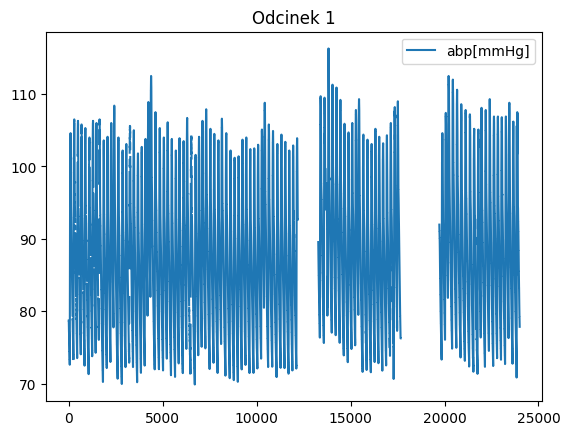

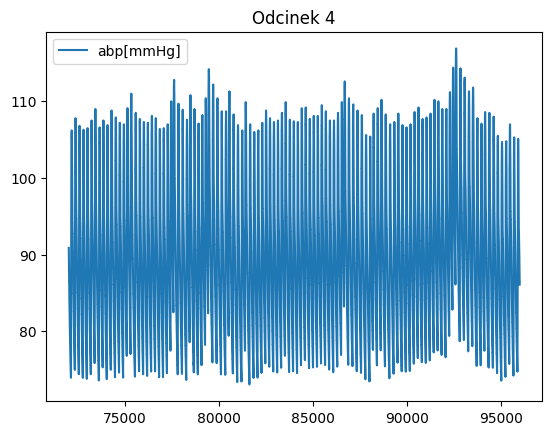

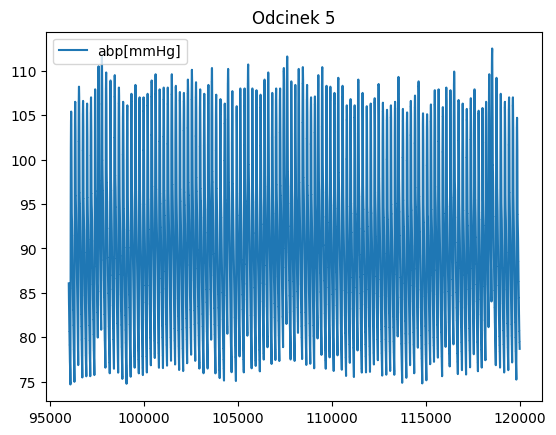

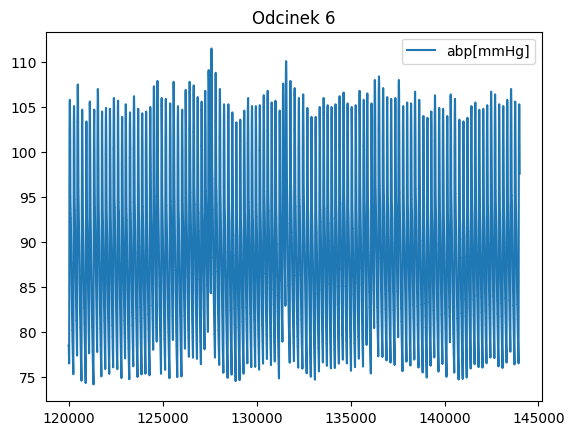

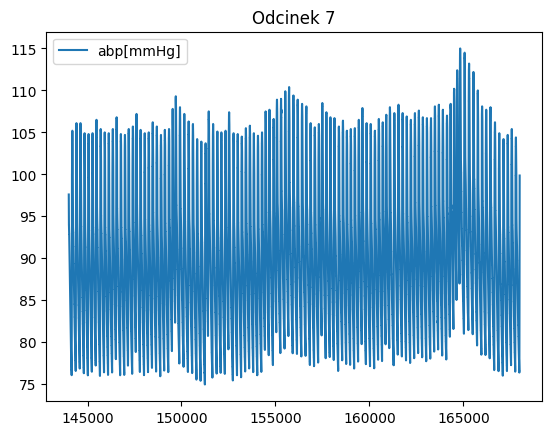

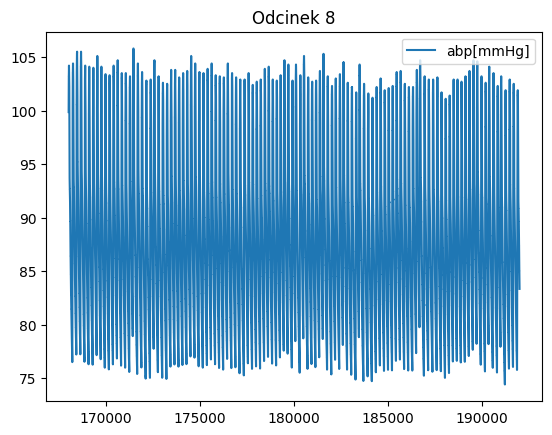

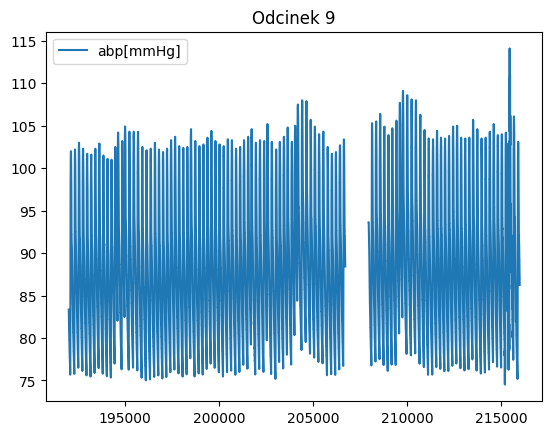

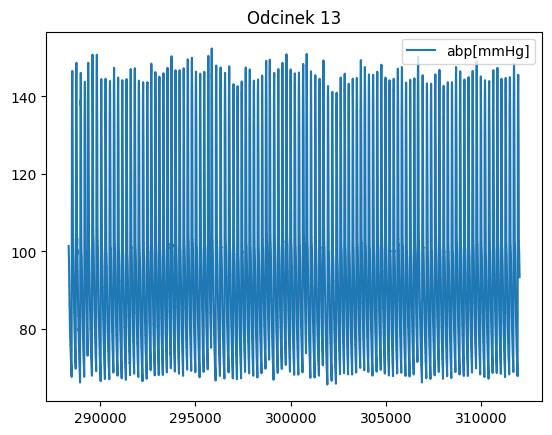

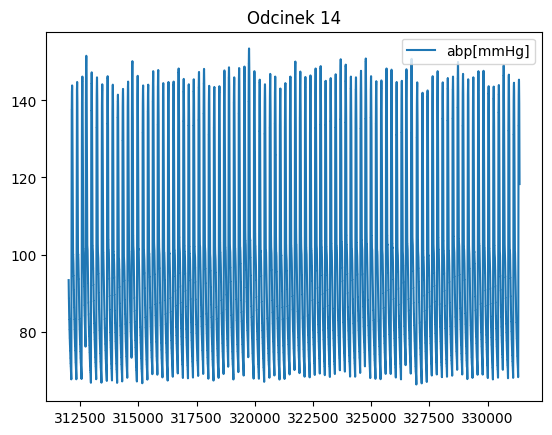

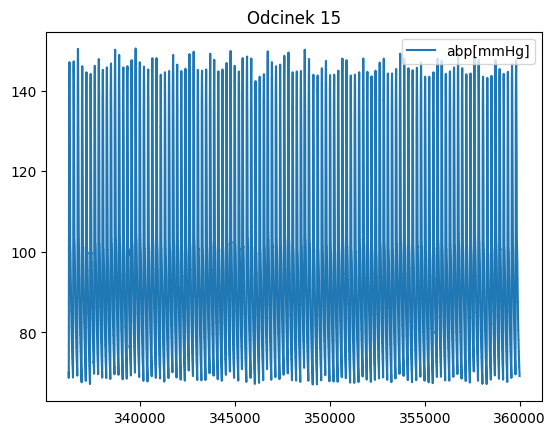

In [9]:
subframes = plot_and_save_subframes(data_1)

# Funckja do autokorelacji

In [10]:
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

def autocorr(df, lags, num, del_linearlity=False):
    """
    Tworzy wykres autokorelacji dla danego fragmentu sygnału,
    del_linearlity odpowiada za usuwanie liniowego wzrostu wartości danych
    """
    df = df.copy()
    
    if del_linearlity == True:
        # Wypełnienie brakujących wartości średnią
        mean_value = df['abp[mmHg]'].mean()
        df.loc[:, 'abp[mmHg]'] = df['abp[mmHg]'].fillna(mean_value)

        X = df['DateTime'].values.reshape(-1,1)
        y = df['abp[mmHg]'].values
        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        df.loc[:, 'detrended'] = y - y_pred
        data = df['detrended'].values
    else:
        data = df['abp[mmHg]'].values

    plot_acf(data, lags=lags)
    plt.title(f'Autokorelacja dla {num}')
    plt.show()
    
    return acf(data, nlags=lags)


Wizualizacja autokorelacji

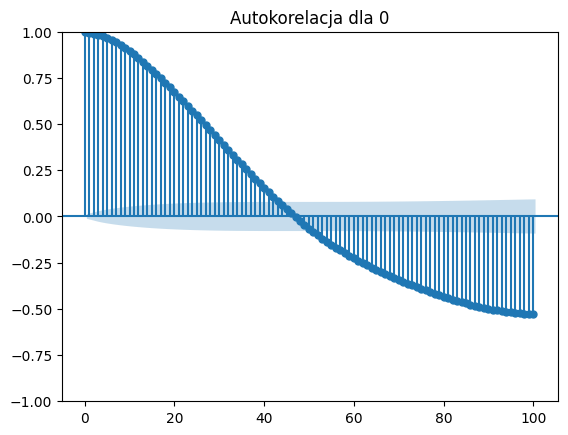

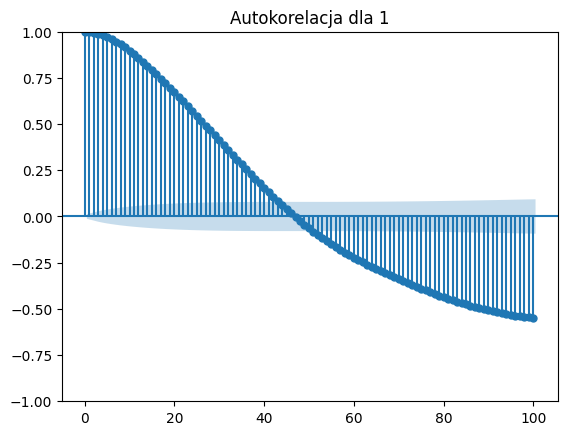

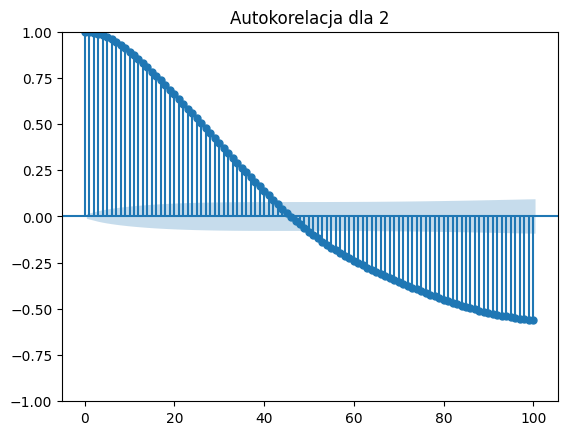

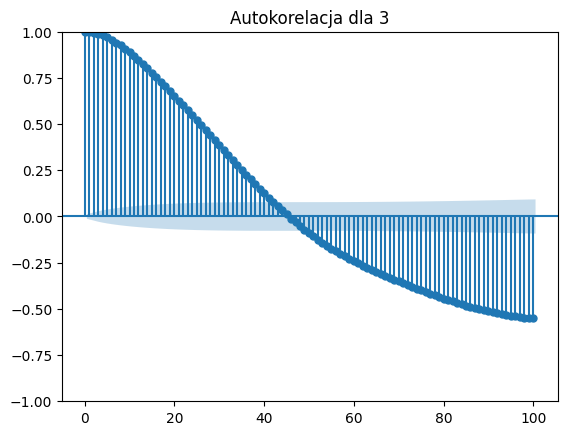

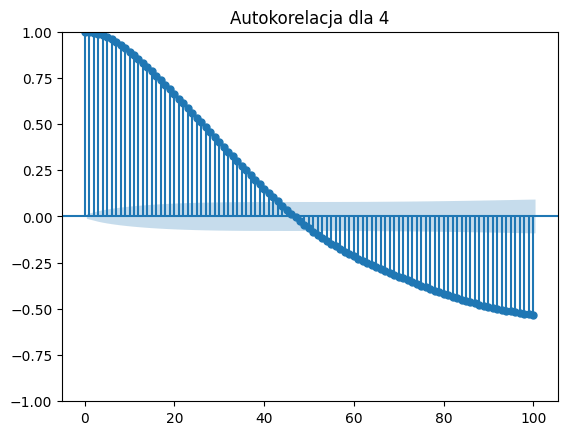

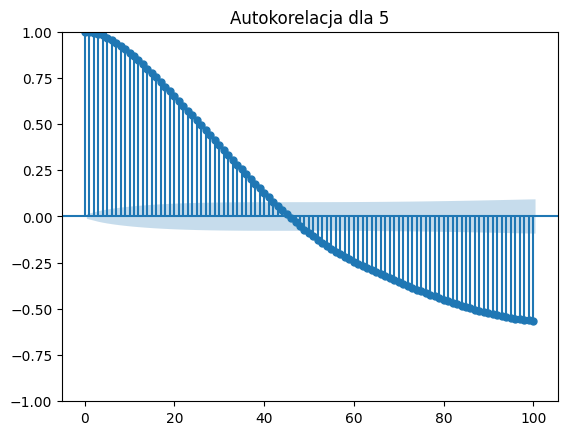

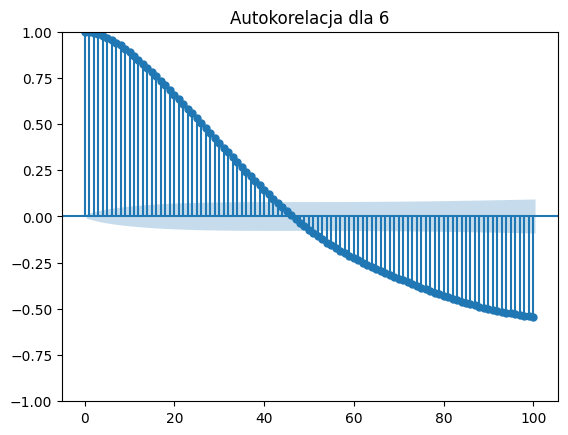

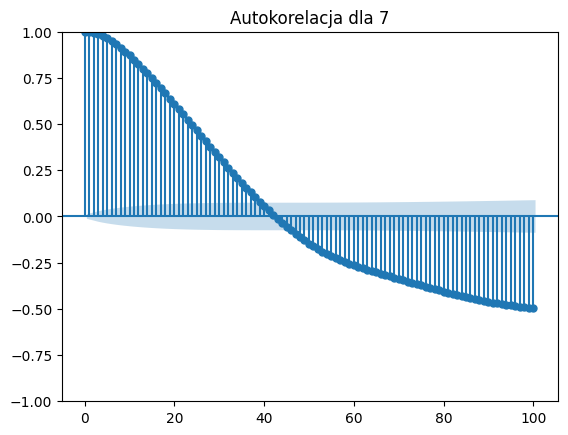

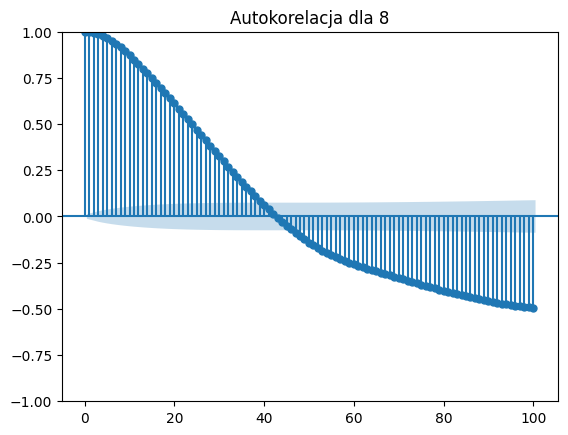

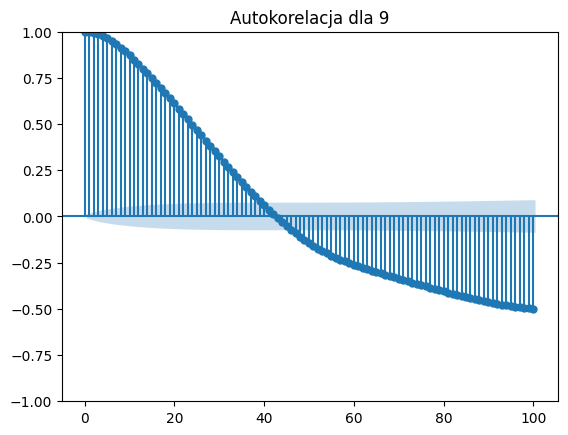

In [11]:
for i, frame in enumerate(subframes):
    autocorr(frame, 100, i, True)


# Porównanie korelacji między fragmentami

In [12]:
def compare_correlation(df1, df2):
    """
    Porównuje korelację między dwoma fragmentami, podając współczynnik korelacji Pearsona.
    
    Args:
    - df1: Pierwsza ramka danych
    - df2: Druga ramka danych
    
    Returns:
    Współczynnik korelacji Pearsona między kolumnami 'abp[mmHg]'
    """
    if len(df1) != len(df2):
        raise ValueError("Ramki danych muszą mieć taką samą długość.")

    signal1 = df1['abp[mmHg]'].values
    signal2 = df2['abp[mmHg]'].values
    
    correlation_matrix = np.corrcoef(signal1, signal2)
    
    # Zwraca wartość korelacji między dwoma sygnałami (poza przekątną macierzy)
    return correlation_matrix[0, 1]

obliczam korelacje między wszystkimi fragmentami bez powtórzeń i bez obliczeń dla autokorelacji.

In [36]:
z = 0
cors = []
for i, sig1 in enumerate(subframes):
    for sig2 in subframes[i+1:]:
        z += 1
        result = compare_correlation(sig1, sig2)
        if np.isnan(result): result = 0 
        print(f'Kor nr {z}, {result}')
        cors.append(result)

Kor nr 1, 0
Kor nr 2, 0
Kor nr 3, 0
Kor nr 4, 0
Kor nr 5, 0
Kor nr 6, 0
Kor nr 7, 0
Kor nr 8, 0
Kor nr 9, 0
Kor nr 10, 0.0259198648030109
Kor nr 11, -0.3055021927998514
Kor nr 12, 0.19569743385422647
Kor nr 13, -0.21210416410987296
Kor nr 14, 0
Kor nr 15, 0
Kor nr 16, 0
Kor nr 17, 0
Kor nr 18, 0.10411593339970474
Kor nr 19, 0.07564514742694405
Kor nr 20, -0.07817999279560131
Kor nr 21, 0
Kor nr 22, 0
Kor nr 23, 0
Kor nr 24, 0
Kor nr 25, -0.06389054707358212
Kor nr 26, 0.0012389924627972872
Kor nr 27, 0
Kor nr 28, 0
Kor nr 29, 0
Kor nr 30, 0
Kor nr 31, -0.2350333694194038
Kor nr 32, 0
Kor nr 33, 0
Kor nr 34, 0
Kor nr 35, 0
Kor nr 36, 0
Kor nr 37, 0
Kor nr 38, 0
Kor nr 39, 0
Kor nr 40, 0
Kor nr 41, 0
Kor nr 42, 0
Kor nr 43, 0
Kor nr 44, 0
Kor nr 45, 0


# Wizualizacja wyników

In [37]:
def analyze_and_plot(cors):
    """
    Analizuje i tworzy wykresy na podstawie listy wartości korelacji.
    
    Args:
    - cors: Lista wartości korelacji
    
    Returns:
    Nic (funkcja wyświetla wykresy)
    """
    
    # Wartość maksymalna
    max_val = np.max(cors)
    print(f'Maksymalna wartość korelacji: {max_val:.4f}')
    
    # Wartość średnia
    mean_val = np.mean(cors)
    print(f'Średnia wartość korelacji: {mean_val:.4f}')
    
    # Histogram
    plt.figure(figsize=(10, 5))
    plt.hist(cors, bins=30, edgecolor='black', alpha=0.7)
    plt.title('Histogram wartości korelacji')
    plt.xlabel('Wartość korelacji')
    plt.ylabel('Liczba wystąpień')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    # Wykres pudełkowy (boxplot)
    plt.figure(figsize=(8, 6))
    plt.boxplot(cors, vert=False)
    plt.title('Wykres pudełkowy wartości korelacji')
    plt.xlabel('Wartość korelacji')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

Maksymalna wartość korelacji: 0.1957
Średnia wartość korelacji: -0.0109


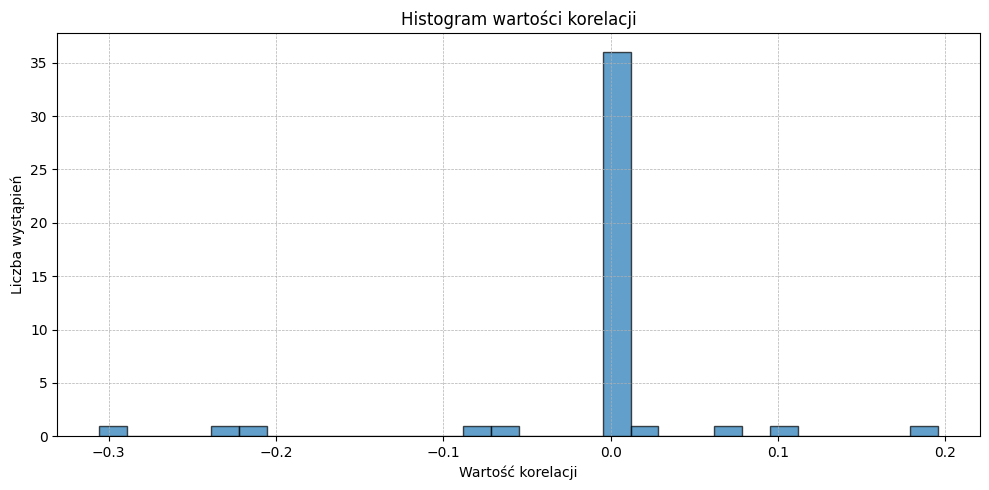

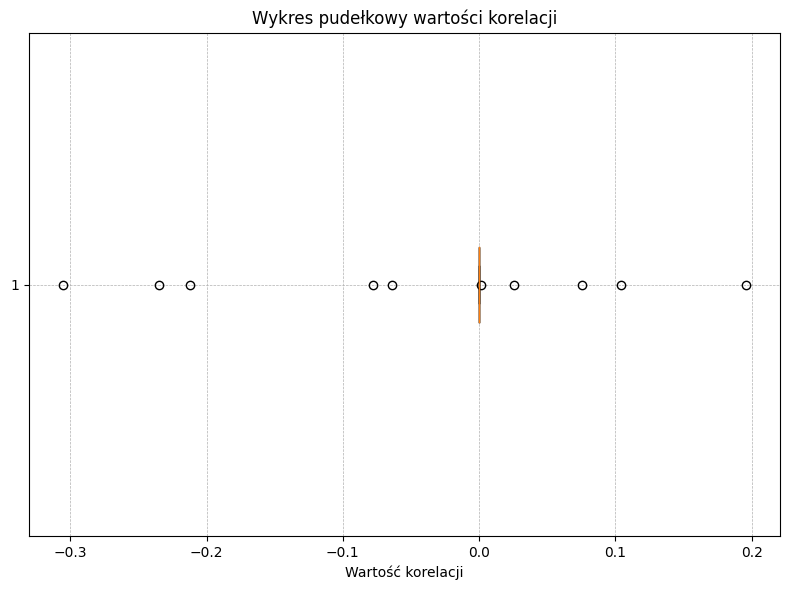

In [38]:
analyze_and_plot(cors)